# Validated joins impeoves utility of joins

In the previous notebook we saw how using concatenation of disjoint synthetic data partitions improved privacy. In this notebook we will play around with having the joins validated by the validator model.

### Example of the joining validator on multiple partitions

Now that we have seen that a model aided by a validator model in the joining step can make the loss in utility less, we should put it inot perspective of the previous experiments with concatenation over multiple partitions. In order to not just repeat another big experiment on the same datasets, we here show the same sort of experiment but on dataset with many more variables. We will use the [diabetic mellitus](https://www.openml.org/search?type=data\&status=active\&id=41430) from OpenML which has 281 records and 98 features. This will simultaneously show that the results shown above holds for many more partitions that what was possible on the smaller datasets, but will also stress test the validation process to select candidates from an increasingly difficult population. 

To keep this experiment within scope, we will use only the synthpop model (most efficient of them). The results are generated again with [02_validator_improves_utility.py](experiments/auxiliaries/02_validator_improves_utility.py), and the results are stored in [02_validator_vs_concat.csv](experiments/results/02_validator_vs_concat.csv).

In [33]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

rcp = {'font.size': 10, 'font.family': 'sans', "mathtext.fontset": "dejavuserif"}
plt.rcParams.update(**rcp)

def concat_adapt_comparison_figure(results, model, dataset, metrics, return_flag=True):

    results = results[results['model']==model]
    results = results[results['data']==dataset]
    
    fig, axes = plt.subplots(int(np.ceil(len(metrics)/3)), 3, figsize=(10, 2.3*np.ceil(len(metrics)/3)), sharex=True)

    axes = axes.flatten()
    for i, metric in enumerate(metrics.keys()):
        axes[i].minorticks_on()
        axes[i].xaxis.set_tick_params(which='minor', bottom=False)
        axes[i].yaxis.grid(True, which='major', linestyle='--', linewidth='0.5', alpha=0.3)
        sns.pointplot(data=results, x="partitions", y=metric, hue='experiment', ax=axes[i], palette='mako', capsize=.1, linewidth=1.5, errorbar='sd')
        axes[i].get_legend().remove()
        axes[i].set_title(metrics[metric], fontsize=10)

        if i % 3 == 0:
            axes[i].set_ylabel("metric value")
        else:
            axes[i].set_ylabel("")

        if i >= len(metrics)-3:
            axes[i].set_xlabel('# parts')
            ticks = axes[i].get_xticks()
            axes[i].set_xticks(ticks, labels=['base', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

    axes[4].legend(loc='upper right')
    plt.tight_layout()

    if return_flag == True:
        return fig
    else:
        plt.savefig(f"experiments/figures/figure3_concat_vs_validate.pdf", bbox_inches='tight')


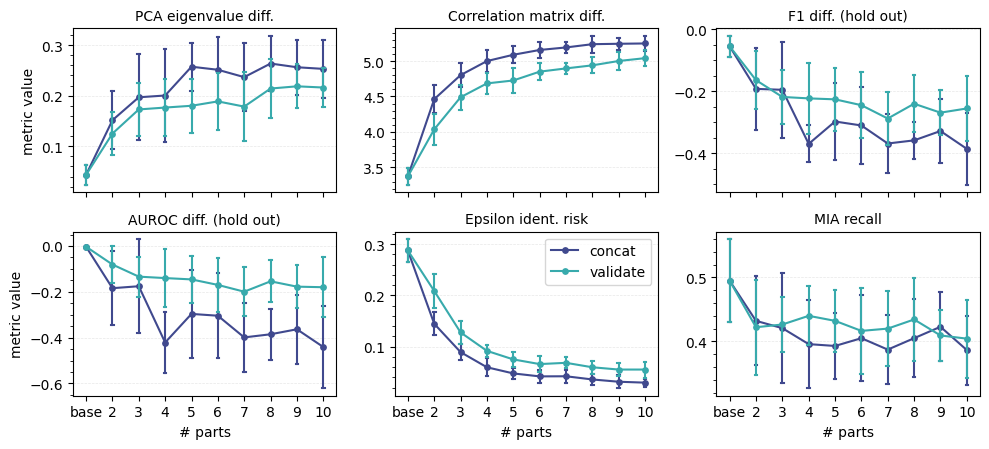

In [34]:
results = pd.read_csv('experiments/results/02_validator_vs_concat.csv')

metrics = {
    "pca_eigval_diff" : "PCA eigenvalue diff.",
    "corr_mat_diff": "Correlation matrix diff.",
    # "avg_h_dist": "Avg. Hellinger dist.",
    "avg_F1_diff_hout": "F1 diff. (hold out)",
    "auroc": "AUROC diff. (hold out)",
    "eps_identif_risk": "Epsilon ident. risk",
    "mia_recall": "MIA recall",
}

fig = concat_adapt_comparison_figure(results, 'datasynthesizer', 'dm', metrics, return_flag=False)

The results show that the DGM using the joining validator quite consistently outperforms the random concatenation scheme. The error bars mark the standard derviation of 20x repeated experiments, and emphasise that it is possible to get a by-chance worse result with the joining validator, but that it is expected to perform better most of the time.  

The plot also shows an intresting effect for correlation matrix difference and epsilon risk that seems to approach upper and lower bound values respectively. 

## Validation is most effective when partitions are correlated

For this experiment we assess the performance of the models using concatenation and validation on dummy data. This data is specifically made such that there is a varying amount of inter and intra correlations between the partitions. The hypothesis being that validation is more effective when the partitions are correlated since the validator model will have more information to work with. Concatenation on the other hand is expected to be only effective when the partitions are uncorrelated, since the concatenation naïvely assumes that the data is independent. 

The data is generated with the [02_correlation_plot.py](experiments/auxiliaries/02_correlation_plot.py) script, and the results are stored in [02_correlation_tradeoff.csv](experiments/results/02_correlation_tradeoff.csv). 

Plotting metric performance vs. inter-partition correlation
Plotting metric performance vs. intra-partition correlation
Plotting metric performance vs. inter/intra correlation ratio


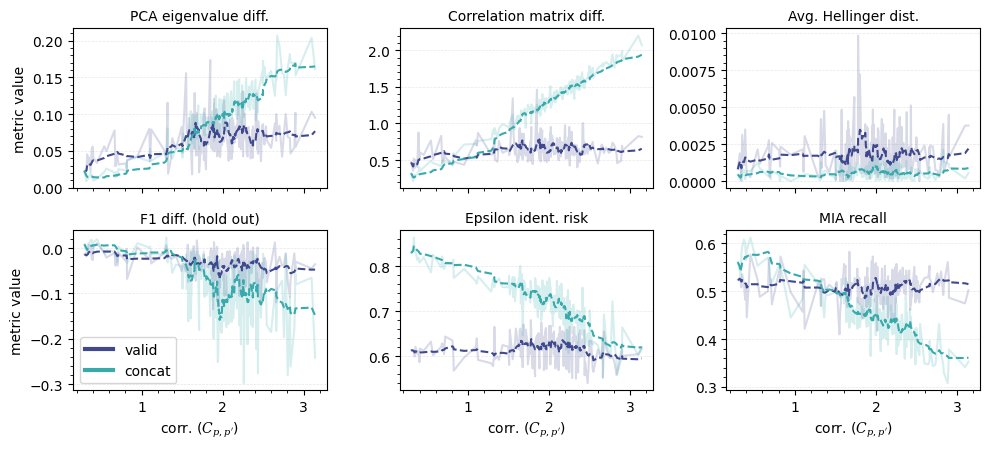

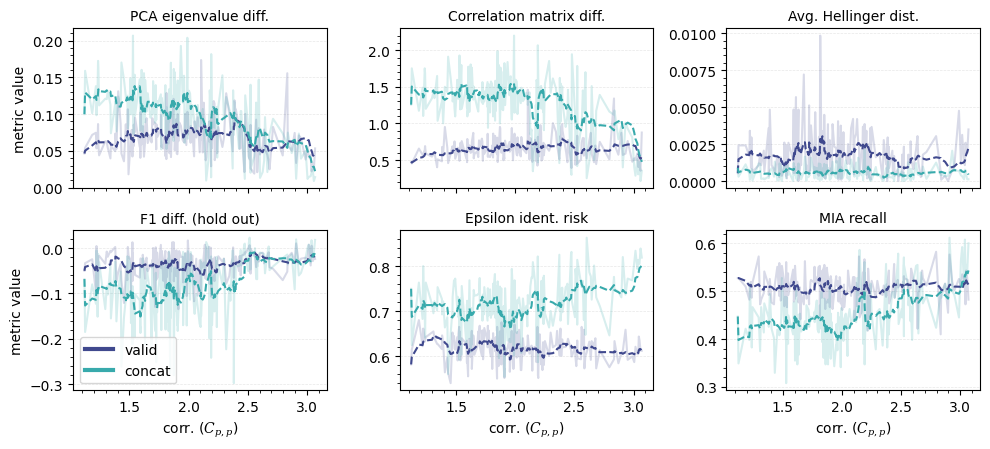

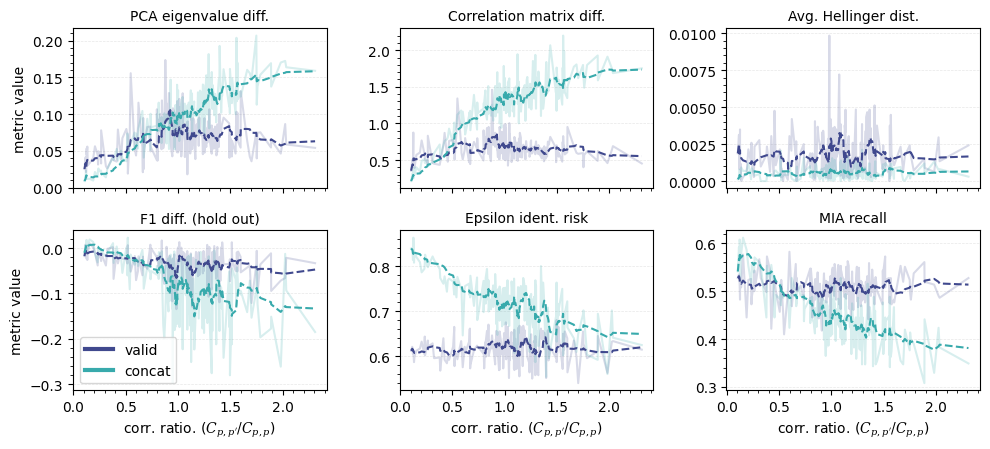

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from typing_extensions import Literal

rcp = {'font.size': 10, 'font.family': 'sans', "mathtext.fontset": "dejavuserif"}
plt.rcParams.update(**rcp)

results = pd.read_csv('experiments/results/02_correlation_tradeoff.csv')

metrics = {
    "pca_eigval_diff" : "PCA eigenvalue diff.",
    "corr_mat_diff": "Correlation matrix diff.",
    "avg_h_dist": "Avg. Hellinger dist.",
    "avg_F1_diff_hout": "F1 diff. (hold out)",
    # "auroc": "AUROC diff. (hold out)",
    "eps_identif_risk": "Epsilon ident. risk",
    "mia_recall": "MIA recall",
}

def concat_tradeoff_figure(results, model, metrics, return_flag=True, mode:Literal['inter', 'intra', 'ratio']='ratio'):
    results = results[results['model']==model]
    
    results['corr_ratio'] = results['corr_inter'] / (results['corr_intra'])

    match mode:
        case 'inter':
            plot_var = 'corr_inter'
            print("Plotting metric performance vs. inter-partition correlation")
        case 'intra':
            plot_var = 'corr_intra'
            print("Plotting metric performance vs. intra-partition correlation")
        case 'ratio':
            plot_var = 'corr_ratio'
            print("Plotting metric performance vs. inter/intra correlation ratio")

    fig, axes = plt.subplots(int(np.ceil(len(metrics)/3)), 3, figsize=(10, 2.3*np.ceil(len(metrics)/3)), sharex=True)

    axes = axes.flatten()
    for i, metric in enumerate(metrics.keys()):
        axes[i].minorticks_on()
        axes[i].yaxis.grid(True, which='major', linestyle='--', linewidth='0.5', alpha=0.3)
        
        sns.lineplot(data=results, x=plot_var, y=metric, hue='joining', ax=axes[i], palette='mako', linewidth=1.5, errorbar=None, alpha=0.2)

        palette = sns.color_palette("mako", n_colors=2)
        for j,join_type in enumerate(results['joining'].unique()):
            subset = results[results['joining'] == join_type]
            subset = subset.sort_values(by=plot_var)
            moving_avg = subset[metric].rolling(window=10, min_periods=1).mean()
            axes[i].plot(subset[plot_var], moving_avg, label=f"{join_type} (MA)", linestyle='--', linewidth=1.5, color=palette[j])

        axes[i].get_legend().remove()
        axes[i].set_title(metrics[metric], fontsize=10)

        if i % 3 == 0:
            axes[i].set_ylabel("metric value")
        else:
            axes[i].set_ylabel("")

        if i >= len(metrics)-3:
            if mode == 'ratio':
                axes[i].set_xlabel(r"corr. ratio. ($C_{p,p'} / C_{p,p}$)")
            elif mode == 'inter':
                axes[i].set_xlabel(r"corr. ($C_{p,p'}$)")
            elif mode == 'intra':
                axes[i].set_xlabel(r"corr. ($C_{p,p}$)")

    custom_lines = [Line2D([0], [0], color=palette[0], lw=3),
                    Line2D([0], [0], color=palette[1], lw=3),]

    axes[3].legend(custom_lines, ['valid', 'concat'], loc='lower left')
    plt.tight_layout()

    if return_flag == True:
        return fig
    else:
        plt.savefig(f"experiments/figures/figure5_correlation_tradeoff_{mode}.pdf", bbox_inches='tight')

fig = concat_tradeoff_figure(results, 'synthpop', metrics, return_flag=False, mode='inter')
fig = concat_tradeoff_figure(results, 'synthpop', metrics, return_flag=False, mode='intra')
fig = concat_tradeoff_figure(results, 'synthpop', metrics, return_flag=False, mode='ratio')

The results show that the joining validator is indeed more effective when the partitions are correlated, while when using concatenation, then performance is very sensitive to the amount of correlation between the partitions.

## Time Measurements of Partitioning

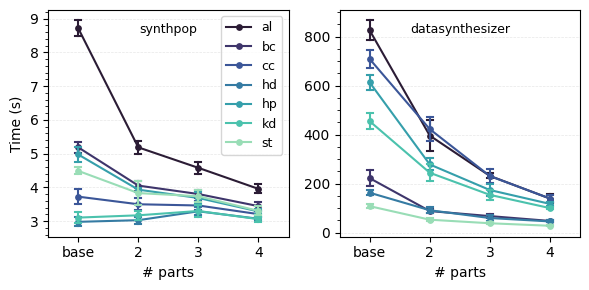

In [38]:
models = ['synthpop', 'datasynthesizer']

results = pd.read_csv('experiments/results/01_utility_privacy_concat.csv')

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=True)

for j, model in enumerate(models):
    axes[j].minorticks_on()
    axes[j].xaxis.set_tick_params(which='minor', bottom=False)
    axes[j].yaxis.grid(True, which='major', linestyle='--', linewidth='0.5', alpha=0.3)
    sns.pointplot(data=results[results['model']==model], x="partitions", y='time', hue="data", ax=axes[j], palette='mako', capsize=.1, linewidth=1.5, errorbar='sd')
    axes[j].get_legend().remove()
    axes[j].annotate(model, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=9)

    axes[j].set_ylabel("Time (s)")

    axes[j].set_xlabel('# parts')
ticks = axes[j].get_xticks()
axes[j].set_xticks(ticks, labels=['base', '2', '3', '4'])
axes[1].set_ylabel("")

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig(f"experiments/figures/figure4a_time_vs_partitions.pdf", bbox_inches='tight')

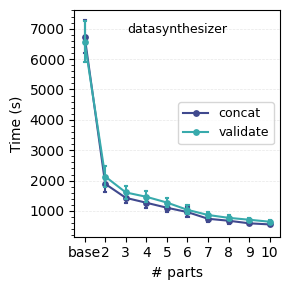

In [40]:
results = pd.read_csv('experiments/results/02_validator_vs_concat.csv')

results_concat = results[results['model']=='datasynthesizer']
results_concat = results[results['data']=='dm']

fig, ax = plt.subplots(1,1,figsize=(3, 3))

ax.minorticks_on()
ax.xaxis.set_tick_params(which='minor', bottom=False)
ax.yaxis.grid(True, which='major', linestyle='--', linewidth='0.5', alpha=0.3)

sns.pointplot(data=results, x="partitions", y='time', hue='experiment', ax=ax, palette='mako', capsize=.1, linewidth=1.5, errorbar='sd')
ax.legend(loc='center right', fontsize=9)
ax.set_ylabel("Time (s)")
ax.set_xlabel('# parts')
ax.annotate('datasynthesizer', xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=9)

ticks = ax.get_xticks()
ax.set_xticks(ticks, labels=['base', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

plt.tight_layout()
plt.savefig(f"experiments/figures/figure4b_time_vs_partitions.pdf", bbox_inches='tight')